# Peptide epitope classifier using pipelines

For each dataset, classifier and folds:
- scaling
- outer CV

Load the libraries for specific calculations:

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# remove warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,f1_score, recall_score, precision_score
from sklearn.utils import class_weight

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.svm import LinearSVC

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import RFECV, VarianceThreshold, SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel, SelectPercentile, f_classif

import feather

### Define script parameters

In [5]:
# define output variables inside the datasets
outVars = ['Epitope']

# define list of folds
foldTypes = [5]

# define a label for output files
targetName = 'Epitopes_Outer'

seed = 42

### Function definitions

In [6]:
def  set_weights(y_data, option='balanced'):
    """Estimate class weights for umbalanced dataset
       If ‘balanced’, class weights will be given by n_samples / (n_classes * np.bincount(y)). 
       If a dictionary is given, keys are classes and values are corresponding class weights. 
       If None is given, the class weights will be uniform """
    cw = class_weight.compute_class_weight(option, np.unique(y_data), y_data)
    w = {i:j for i,j in zip(np.unique(y_data), cw)}
    return w 

In [7]:
def getDataFromDataset(sFile, OutVar):
    """Retrieve the X data, Y data and names of features
       from a specific dataset sFile with a specific output variable OutVar"""
        
    # read details file
    print('\n-> Read dataset', sFile)
    df = pd.read_csv(sFile)
    #df = feather.read_dataframe(sFile)
    
    # remove duplicates!
    df.drop_duplicates(keep=False, inplace=True)
    
    print('Shape', df.shape)
    # print(list(df.columns))

    # select X and Y
    ds_y = df[OutVar]
    ds_X = df.drop(OutVar,axis = 1)
    Xdata = ds_X.values # get values of features
    Ydata = ds_y.values # get output values

    print('Shape X data:', Xdata.shape)
    print('Shape Y data:',Ydata.shape)
    
    # return data for X and Y, feature names as list
    return (Xdata, Ydata, list(ds_X.columns))

In [9]:
def Pipeline_OuterCV(Xdata, Ydata, label = 'my', class_weights = {0: 1, 1: 1}, folds = 3, seed = 42):
    """Calculate the AUROC values for 7 ML methods using pipelines with standardize and n-fold CV"""
    # inputs:
    # data for X, Y; a label about data, number of folds, seeed
    # default: 3-fold CV, 1:1 class weights (ballanced dataset)
    
    # define classifiers using class weighting
    names = ['KNN', 'SVM linear', 'SVM', 'LR', 'DT', 'RF', 'XGB']
    classifiers = [KNeighborsClassifier(5),
                   SVC(kernel="linear",random_state=seed,gamma='scale',class_weight=class_weights),
                   SVC(kernel = 'rbf', random_state=seed,gamma='scale',class_weight=class_weights),
                   LogisticRegression(solver='lbfgs',random_state=seed,class_weight=class_weights),
                   DecisionTreeClassifier(random_state = seed,class_weight=class_weights),
                   RandomForestClassifier(n_jobs=-1,random_state=seed,class_weight=class_weights),
                   XGBClassifier(n_jobs=-1,seed=seed,scale_pos_weight= class_weights[0]/class_weights[1])
                  ]
    # results dataframe: each column for a classifier
    df_res = pd.DataFrame(columns=names)

    # build each classifier
    print('* Building scaling+feature selection+outer '+str(folds)+'-fold CV for '+str(len(names))+' classifiers:', str(names))
    total = time.time()
    
    # define a fold-CV for all the classifier
    outer_cv = StratifiedKFold(n_splits=folds,shuffle=True,random_state=seed)
    
    for name, clf in zip(names, classifiers):
        start = time.time()
        
        # create pipeline: scaler + classifier
        estimators = []
        
        # add a scaler
        estimators.append(('Scaler', StandardScaler() ))
        
        # add a classifier
        estimators.append(('Classifier', clf)) 
        
        # create pipeline
        model = Pipeline(estimators)
        
        # evaluate pipeline
        scores = cross_val_score(model, Xdata, Ydata, cv=outer_cv, scoring='roc_auc', n_jobs=-1)
        
        df_res[name] = scores
        print('%s, MeanAUC=%0.2f, Time:%0.1f mins' % (name, scores.mean(), (time.time() - start)/60))
        
    print('Total time:', (time.time() - total)/60, ' mins')             
    
    # return AUC scores for all classifiers as dataframe (each column a classifier)
    return df_res

### Calculations of AUROC values

In [10]:
# for each subset file
df_results = None # all results 

for OutVar in outVars:
    sFile = './datasets/ds.'+str(OutVar)+'.csv'

    # get data from file
    Xdata, Ydata, Features = getDataFromDataset(sFile,OutVar)

    # Calculate class weights
    class_weights = set_weights(Ydata)
    print("Class weights = ", class_weights)
        
    # try different folds for each subset -> box plots
    for folds in foldTypes:
        
        # calculate outer CV for different binary classifiers
        df_fold = Pipeline_OuterCV(Xdata, Ydata, label = OutVar, class_weights = class_weights, folds = folds, seed = seed)
        df_fold['Dataset'] = OutVar
        df_fold['folds'] = folds
        
        # add each result to a summary dataframe
        df_results = pd.concat([df_results,df_fold])


-> Read dataset ./datasets/ds.Epitope.csv
Shape (709100, 11)
Shape X data: (709100, 10)
Shape Y data: (709100,)
Class weights =  {0: 0.7710257001317844, 1: 1.422421747747314}
* Building scaling+feature selection+outer 5-fold CV for 7 classifiers: ['KNN', 'SVM linear', 'SVM', 'LR', 'DT', 'RF', 'XGB']
KNN, MeanAUC=0.90, Time:12.1 mins
SVM linear, MeanAUC=0.79, Time:297.4 mins
SVM, MeanAUC=0.86, Time:679.1 mins
LR, MeanAUC=0.82, Time:0.1 mins
DT, MeanAUC=0.92, Time:0.2 mins
RF, MeanAUC=0.97, Time:0.3 mins
XGB, MeanAUC=0.89, Time:0.7 mins
Total time: 989.9264093399048  mins


In [11]:
# save all results as CSV
summaryFile = './results/Summary_'+targetName+'CV.csv'
print('\n==>> Saving summary', summaryFile)
df_results.to_csv(summaryFile, index=False)
df_results


==>> Saving summary ./results/Summary_Epitopes_OuterCV.csv


KNN  SVM linear       SVM        LR        DT        RF       XGB  \
0  0.900426    0.784715  0.866211  0.817914  0.923289  0.974079  0.892068   
1  0.898101    0.799922  0.862916  0.816066  0.923048  0.972909  0.890305   
2  0.899825    0.788554  0.863746  0.815855  0.922731  0.973127  0.889631   
3  0.898191    0.798953  0.865833  0.815980  0.922772  0.972198  0.888771   
4  0.897206    0.789755  0.861782  0.813802  0.923465  0.971392  0.887475   

   Dataset  folds  
0  Epitope      5  
1  Epitope      5  
2  Epitope      5  
3  Epitope      5  
4  Epitope      5

## Box plots from results

Load the results from file (if you dont want to run the previous calculations):

In [12]:
summaryFile = './results/Summary_'+targetName+'CV.csv'
print('\n-> Read summary results', summaryFile)
df_results = pd.read_csv(summaryFile)


-> Read summary results ./results/Summary_Epitopes_OuterCV.csv


Get list of classifiers from output file:

In [13]:
classifierNames = list(df_results.columns)
classifierNames.remove('Dataset')
classifierNames.remove('folds')
classifierNames

['KNN', 'SVM linear', 'SVM', 'LR', 'DT', 'RF', 'XGB']

Get list of folds:

In [14]:
foldTypes = list(set(df_results['folds']))
foldTypes.sort()
foldTypes

[5]

### Boxplots by Dataset

Create grouped plots for each dataset and number of folds:

==> Fold = 5


<Figure size 432x288 with 0 Axes>

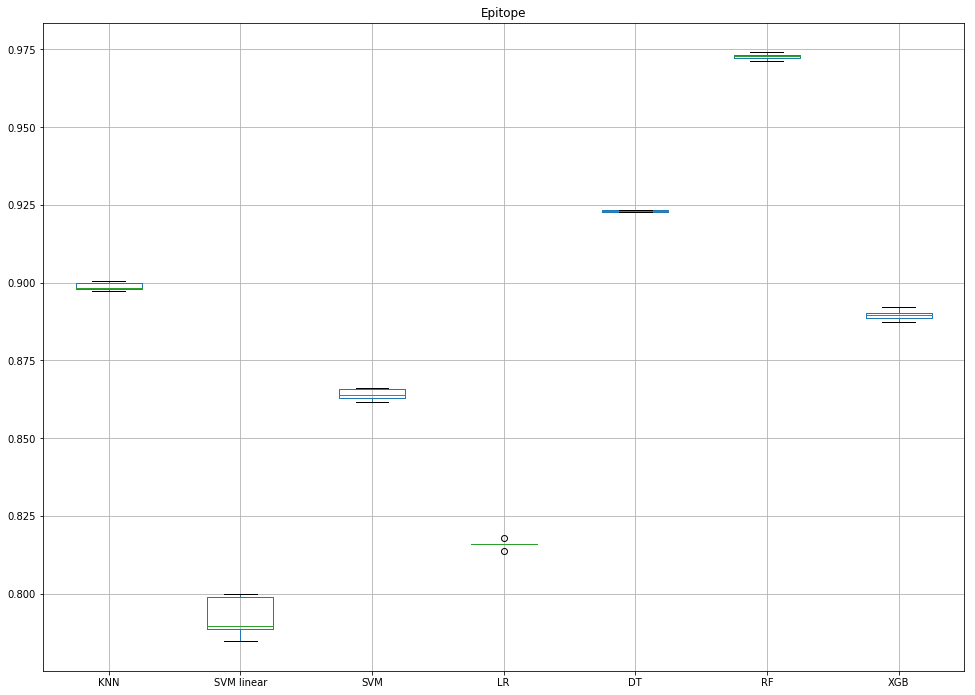

In [15]:
for f in foldTypes:
    plt.figure()
    plt.clf()
    print('==> Fold =', f)
    grouped = df_results[df_results['folds']==f].drop(['folds'], axis=1).groupby('Dataset')
    grouped.boxplot(figsize=(16,12), return_type='axes')
    plt.savefig('./results/byDataset_'+targetName+'-'+str(f)+'-foldCV.png')
    plt.show()

Have fun with ML!
@muntisa